Combine ECG and RR features

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tomkin import detect_rpeak
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from outlier_calculation import Quality,compute_outlier_ecg
# from hrvanalysis import remove_ectopic_beats
from joblib import Parallel,delayed
from data_quality import ECGQualityCalculation
from joblib import delayed,Parallel
from copy import deepcopy
from ecg import ecg_feature_computation
from scipy import interpolate
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler,RobustScaler,QuantileTransformer
import gzip

def rip_cycle_feature_computation(peaks_datastream: np.ndarray,
                                  valleys_datastream: np.ndarray) -> np.ndarray:
    """
    Respiration Feature Implementation. The respiration feature values are
    derived from the following paper:
    'puffMarker: a multi-sensor approach for pinpointing the timing of first lapse in smoking cessation'
    Removed due to lack of current use in the implementation
    roc_max = []  # 8. ROC_MAX = max(sample[j]-sample[j-1])
    roc_min = []  # 9. ROC_MIN = min(sample[j]-sample[j-1])

    :param peaks_datastream: list of peak datapoints
    :param valleys_datastream: list of valley datapoints
    :return: lists of DataPoints each representing a specific feature calculated from the respiration cycle
    found from the peak valley inputs
    """

    inspiration_duration = []  # 1 Inhalation duration
    expiration_duration = []  # 2 Exhalation duration
    respiration_duration = []  # 3 Respiration duration
    inspiration_expiration_ratio = []  # 4 Inhalation and Exhalation ratio
    stretch = []  # 5 Stretch
    upper_stretch = []  # 6. Upper portion of the stretch calculation
    lower_stretch = []  # 7. Lower portion of the stretch calculation
    delta_previous_inspiration_duration = []  # 10. BD_INSP = INSP(i)-INSP(i-1)
    delta_previous_expiration_duration = []  # 11. BD_EXPR = EXPR(i)-EXPR(i-1)
    delta_previous_respiration_duration = []  # 12. BD_RESP = RESP(i)-RESP(i-1)
    delta_previous_stretch_duration = []  # 14. BD_Stretch= Stretch(i)-Stretch(i-1)
    delta_next_inspiration_duration = []  # 19. FD_INSP = INSP(i)-INSP(i+1)
    delta_next_expiration_duration = []  # 20. FD_EXPR = EXPR(i)-EXPR(i+1)
    delta_next_respiration_duration = []  # 21. FD_RESP = RESP(i)-RESP(i+1)
    delta_next_stretch_duration = []  # 23. FD_Stretch= Stretch(i)-Stretch(i+1)
    neighbor_ratio_expiration_duration = []  # 29. D5_EXPR(i) = EXPR(i) / avg(EXPR(i-2)...EXPR(i+2))
    neighbor_ratio_stretch_duration = []  # 32. D5_Stretch = Stretch(i) / avg(Stretch(i-2)...Stretch(i+2))

    valleys = valleys_datastream
    peaks = peaks_datastream[:-1]

    for i, peak in enumerate(peaks):
        valley_start_time = valleys[i][0]
        valley_end_time = valleys[i + 1][0]

        delta = peak[0] - valleys[i][0]
        inspiration_duration.append(np.array([valley_start_time,valley_end_time,delta/1000]))

        delta = valleys[i + 1][0] - peak[0]
        expiration_duration.append(np.array([valley_start_time,valley_end_time,delta/1000]))

        delta = valleys[i + 1][0] - valley_start_time
        respiration_duration.append(np.array([valley_start_time,valley_end_time,delta/1000]))

        ratio = (peak[0] - valley_start_time) / (valleys[i + 1][0] - peak[0])
        inspiration_expiration_ratio.append(np.array([valley_start_time,valley_end_time,ratio]))

        value = peak[1] - valleys[i + 1][1]
        stretch.append(np.array([valley_start_time,valley_end_time,value]))

    for i, point in enumerate(inspiration_duration):
        valley_start_time = valleys[i][0]
        valley_end_time = valleys[i + 1][0]
        if i == 0:  # Edge case
            delta_previous_inspiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_previous_expiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_previous_respiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_previous_stretch_duration.append(np.array([valley_start_time,valley_end_time,0]))
        else:
            delta = inspiration_duration[i][2] - inspiration_duration[i - 1][2]
            delta_previous_inspiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = expiration_duration[i][2] - expiration_duration[i - 1][2]
            delta_previous_expiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = respiration_duration[i][2] - respiration_duration[i - 1][2]
            delta_previous_respiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = stretch[i][2] - stretch[i - 1][2]
            delta_previous_stretch_duration.append(np.array([valley_start_time,valley_end_time,delta]))

        if i == len(inspiration_duration) - 1:
            delta_next_inspiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_next_expiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_next_respiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_next_stretch_duration.append(np.array([valley_start_time,valley_end_time,0]))
        else:
            delta = inspiration_duration[i][2] - inspiration_duration[i + 1][2]
            delta_next_inspiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = expiration_duration[i][2] - expiration_duration[i + 1][2]
            delta_next_expiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = respiration_duration[i][2] - respiration_duration[i + 1][2]
            delta_next_respiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = stretch[i][2] - stretch[i + 1][2]
            delta_next_stretch_duration.append(np.array([valley_start_time,valley_end_time,delta]))

        stretch_average = 0
        expiration_average = 0
        count = 0.0
        for j in [-2, -1, 1, 2]:
            if i + j < 0 or i + j >= len(inspiration_duration):
                continue
            stretch_average += stretch[i + j][2]
            expiration_average += expiration_duration[i + j][2]
            count += 1

        stretch_average /= count
        expiration_average /= count

        ratio = stretch[i][2] / stretch_average
        neighbor_ratio_stretch_duration.append(np.array([valley_start_time,valley_end_time,ratio]))

        ratio = expiration_duration[i][2] / expiration_average
        neighbor_ratio_expiration_duration.append(np.array([valley_start_time,valley_end_time,ratio]))

    # Begin assembling datastream for output
    inspiration_duration_datastream = np.array(inspiration_duration)[1:-1]

    expiration_duration_datastream = np.array(expiration_duration)[1:-1]

    respiration_duration_datastream = np.array(respiration_duration)[1:-1]

    inspiration_expiration_ratio_datastream = np.array(inspiration_expiration_ratio)[1:-1]

    stretch_datastream = np.array(stretch)[1:-1]

    delta_previous_inspiration_duration_datastream = np.array(delta_previous_inspiration_duration)[1:-1]

    delta_previous_expiration_duration_datastream = np.array(delta_previous_expiration_duration)[1:-1]

    delta_previous_respiration_duration_datastream = np.array(delta_previous_respiration_duration)[1:-1]

    delta_previous_stretch_duration_datastream = np.array(delta_previous_stretch_duration)[1:-1]

    delta_next_inspiration_duration_datastream = np.array(delta_next_inspiration_duration)[1:-1]

    delta_next_expiration_duration_datastream = np.array(delta_next_expiration_duration)[1:-1]

    delta_next_respiration_duration_datastream = np.array(delta_next_respiration_duration)[1:-1]

    delta_next_stretch_duration_datastream = np.array(delta_next_stretch_duration)[1:-1]

    neighbor_ratio_expiration_datastream = np.array(neighbor_ratio_expiration_duration)[1:-1]

    neighbor_ratio_stretch_datastream = np.array(neighbor_ratio_stretch_duration)[1:-1]

    return np.concatenate([inspiration_duration_datastream,
                           expiration_duration_datastream[:,2].reshape(-1,1),
                           respiration_duration_datastream[:,2].reshape(-1,1),
                           inspiration_expiration_ratio_datastream[:,2].reshape(-1,1),
                           stretch_datastream[:,2].reshape(-1,1),
                           delta_previous_inspiration_duration_datastream[:,2].reshape(-1,1),
                           delta_previous_expiration_duration_datastream[:,2].reshape(-1,1),
                           delta_previous_respiration_duration_datastream[:,2].reshape(-1,1),
                           delta_previous_stretch_duration_datastream[:,2].reshape(-1,1),
                           delta_next_inspiration_duration_datastream[:,2].reshape(-1,1),
                           delta_next_expiration_duration_datastream[:,2].reshape(-1,1),
                           delta_next_respiration_duration_datastream[:,2].reshape(-1,1),
                           delta_next_stretch_duration_datastream[:,2].reshape(-1,1),
                           neighbor_ratio_expiration_datastream[:,2].reshape(-1,1),
                           neighbor_ratio_stretch_datastream[:,2].reshape(-1,1)],axis=1)

def get_windows(data,window_size=10,offset=10,fs=1):
    ts_array = np.arange(data[0,0],data[-1,0],offset*1000)
    window_col = []
    for t in ts_array:
        index = np.where((data[:,0]>t-window_size*1000/2)&(data[:,0]<=t+window_size*1000/2))[0]
        if len(index)<30:
            continue
        window_col.append(data[index,:])
    return window_col

def get_std_chest(window,start=1,end=4):
    return np.array([np.mean(window[:,0]),np.sqrt(np.sum(np.power(np.std(window[:,start:end],axis=0),2)))])


def filter_ecg_windows(ecg_windows,acl_std):
    final_ecg_windows = []
    for window in ecg_windows:
        index = np.where((acl_std[:,0]>window[0,0])&(acl_std[:,0]<window[-1,0]))[0]
        if len(index)==0:
            continue
        window_temp = acl_std[index,1].reshape(-1)
        if len(window_temp[window_temp>.21])/len(window_temp) > .5:
            continue
        final_ecg_windows.append(window)
    return final_ecg_windows

def get_rip_windows(data,window_size=60,offset=10,fs=.2):
    ts_array = np.arange(data[0,0],data[-1,0],offset*1000)
    window_col = []
    for t in ts_array:
        index = np.where((data[:,0]>=t-window_size*1000/2)&(data[:,1]<=t+window_size*1000/2))[0]
        if len(index)<10:
            continue
        window_col.append(data[index,:])
    return window_col

def get_all_windows(data,rip_data,window_size=60,offset=10,fs=.2):
    ts_array = np.arange(data[0,0],data[-1,0],offset*1000)
    window_col = []
    for t in ts_array:
        index = np.where((data[:,0]>=t-window_size*1000/2)&(data[:,0]<=t+window_size*1000/2))[0]
        index_rip = np.where((rip_data[:,0]>=t-window_size*1000/2)&(rip_data[:,1]<=t+window_size*1000/2))[0]
        if len(index)<30 or len(index_rip)<10:
            continue
        window_col.append([data[index,:],rip_data[index_rip,:]])
    return window_col
def get_features(a):
    window = a[0]
    ecg_feature = ecg_feature_computation(window[:,0],window[:,1])
    window = a[1]
    rip_feature = list(np.mean(window[:,2:],axis=0))+list(np.std(window[:,2:],axis=0))+ \
    list(np.percentile(window[:,2:],80,axis=0))+list(np.percentile(window[:,2:],20,axis=0))
    feature = list([window[0,0],window[-1,0]])+ecg_feature+rip_feature
    return np.array(feature)
    
import warnings 
warnings.filterwarnings('ignore')
    
path = './data/'
participants = [path + f +'/' for f in os.listdir(path) if f[0]=='S']
for f in participants:
    if 'ecg.txt.gz' not in os.listdir(f):
        continue
    if os.path.isfile(f+'ecg_rr.p') and os.path.isfile(f+'pv.p') :
        ecg_rr = pickle.load(open(f+'ecg_rr.p','rb'))
        ecg_rr_baseline = ecg_rr
        from scipy import stats
        ecg_rr[:,1] = stats.mstats.winsorize(ecg_rr[:,1],limits=.01)
        
        peaks,valleys = pickle.load(open(f+'pv.p','rb'))
        rip_features = rip_cycle_feature_computation(peaks,valleys)
        rip_features = rip_features[:,np.array([0,1,2,3,4,5,6,7,8,-2,-1])]
        for c in range(2,rip_features.shape[1]):
            rip_features[:,c] = stats.mstats.winsorize(rip_features[:,c],limits=.01)
            
        all_windows = get_all_windows(ecg_rr,rip_features,window_size=60,offset=10,fs=1)
        all_features = np.array(list(map(lambda a:get_features(a),all_windows)))
        for i in range(2,all_features.shape[1],1):
            all_features[:,i] = StandardScaler().fit_transform(all_features[:,i].reshape(-1,1)).reshape(-1)
        pickle.dump(all_features,open(f+'features_rip_ecg.p','wb'))
        print(all_features.shape)

(712, 49)
(752, 49)
(720, 49)
(759, 49)
(820, 49)
(337, 49)
(790, 49)
(772, 49)
(750, 49)
(604, 49)
(811, 49)
(770, 49)
(656, 49)
(769, 49)
(673, 49)
(753, 49)
(633, 49)


In [2]:
# Soujanya Chatterjee
	
# 2:06 PM (9 minutes ago)
	
# to me
import pandas as pd, numpy as np, os, csv, glob, math, matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from scipy.stats import *
import gzip
import pickle
from collections import Counter

def find_majority(k):
    myMap = {}
    maximum = ( '', 0 ) # (occurring element, occurrences)
    for n in k:
        if n in myMap: myMap[n] += 1
        else: myMap[n] = 1

        # Keep track of maximum on the go
        if myMap[n] > maximum[1]: maximum = (n,myMap[n])

    return maximum[0]

# _dir = 'W:\\Students\\cstress_features\\data\\data\\SI02\\'

def decodeLabel(label):
    label = label[:2]  # Only the first 2 characters designate the label code

    mapping = {'c1': 0, 'c2': 1, 'c3': 1, 'c4': 0, 'c5': 0, 'c6': 0, 'c7': 2}

    return mapping[label]

def readstressmarks(participantID, filename):
    features = []
    for file in os.listdir(filename):    
        if file.endswith("marks.txt.gz"):        
            with gzip.open(os.path.join(filename, file), 'r') as file:
                for line in file.readlines():
                    line = line.decode('utf8').strip()
                    parts = [x.strip() for x in line.split(',')]                    
                    label = parts[0][:2]  
                    if label not in ['c7','c6']:
                        stressClass = decodeLabel(label)
                        features.append([participantID, stressClass, int(parts[2]), int(parts[3])])
    return np.array(features)

_dirr = './data/'
parti = np.array(os.listdir(_dirr) )
header = ['participant','starttime','endtime','label'] + ['f_'+str(i) for i in range(47)]
fea_cols = ['f_'+str(i) for i in range(47)]
data = []
for p in parti:
    print(p)
    if p in ['feature.csv','feature_ecg.csv','feature_rip.csv','feature_all.csv',
             '.ipynb_checkpoints']:
        continue
    else:
        if os.path.isdir(os.path.join(_dirr,p)):
            _dir = (os.path.join(_dirr,p))
            gt_marks = readstressmarks(p,_dir)
            if len(gt_marks)==0:
                continue
            groundtruth = pd.DataFrame({'participant': gt_marks[:, 0], 'label': gt_marks[:, 1], 'starttime': gt_marks[:, 2],
                                        'endtime': gt_marks[:, 3]}, columns=['participant','label','starttime','endtime'])
            groundtruth = groundtruth.sort_values('starttime')
   
            check = False
            for file in os.listdir(_dir):    
                    if file.endswith('features_rip_ecg.p'):                    
                        with open(_dir+'/'+file, 'rb') as f:  
                            x = pickle.load(f)
                            check  =True
            if not check:
                continue
#             print(x.shape)
#             dataset = pd.DataFrame({'starttime': x[:, 0], 'endtime': x[:, 1], 'f_1': x[:, 2]
#                                    , 'f_2': x[:, 3], 'f_3': x[:, 4], 'f_4': x[:, 5]
#                                    , 'f_5': x[:, 6], 'f_6': x[:, 7], 'f_7': x[:, 8]
#                                    , 'f_8': x[:, 9], 'f_9': x[:, 10], 'f_10': x[:, 11]
#                                    , 'f_11': x[:, 12]}, columns=['starttime','endtime','f_1','f_2','f_3','f_4','f_5','f_6','f_7','f_8',
#                                                                  'f_9','f_10','f_11'])
            
            dataset = pd.DataFrame(x,columns=['starttime','endtime']+['f_'+str(i) for i in range(x.shape[1]-2)])
            dataset = dataset.sort_values('starttime')

            for gt in range(len(dataset)):
                starttime = int(dataset['starttime'].iloc[gt])
                endtime = int(dataset['endtime'].iloc[gt])
                result = []
                for line in range(len(groundtruth)):
                    id, gtt, st, et = [groundtruth['participant'].iloc[line], groundtruth['label'].iloc[line], int(groundtruth['starttime'].iloc[line]),
                                      int(groundtruth['endtime'].iloc[line])]
                    if starttime < st:
                        continue
                    else:
                        if (starttime > st) and (endtime < et):
                            result.append(gtt)
                        if result:
                            fea = list(dataset[fea_cols].iloc[gt])
                            inter_data = [p, st,et,find_majority(result)],(fea)
                            flatten = lambda l: [item for sublist in l for item in sublist]

                            data.append(flatten(inter_data))
    #         print(data)
df = pd.DataFrame(data)
df.fillna(df.mean(),inplace=True)
print(df.shape)
df.to_csv(_dirr + '/' + 'feature_rip_ecg.csv', index=False, header=header)

.DS_Store
SI01
SI02
SI03
SI04
SI05
SI06
SI07
SI08
SI09
SI10
SI11
SI12
SI13
SI14
SI15
SI16
SI17
SI18
SI19
SI20
SI21
SI22
SI23
SI24
.ipynb_checkpoints
feature.csv
feature_rip.csv
feature_ecg.csv
feature_all.csv
feature_rip_ecg.csv
feature_ecg_norm.csv
(6926, 51)


In [3]:
feature_file = './data/feature_rip_ecg.csv'
feature = pd.read_csv(feature_file).values
y = np.int64(feature[:,3])
X = feature[:,4:4+11]
groups = feature[:,0]
print(X.shape,y.shape,np.sum(y),np.unique(y),len(np.unique(groups)))

(6926, 11) (6926,) 1347 [0 1] 17


In [4]:
### from sklearn.decomposition import PCA
from pprint import pprint
import numpy as np
# import parfit.parfit as pf
from sklearn.base import clone, is_classifier
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
# from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score,classification_report
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline
import warnings
from sklearn.model_selection import check_cv
from sklearn.externals.joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, ParameterGrid
from sklearn.utils.validation import _num_samples, indexable
warnings.filterwarnings('ignore')
from sklearn import metrics

def Twobias_scorer_CV(probs, y, ret_bias=False):
    db = np.transpose(np.vstack([np.array(probs).reshape(-1), np.array(y).reshape(-1)]))
    db = db[np.argsort(db[:, 0]), :]

    pos = np.sum(y == 1)
    n = len(y)
    neg = n - pos
    tp, tn = pos, 0
    lost = 0

    optbias = []
    minloss = 1

    for i in range(n):
        #		p = db[i,1]
        if db[i, 1] == 1:  # positive
            tp -= 1.0
        else:
            tn += 1.0

        # v1 = tp/pos
        #		v2 = tn/neg
        if tp / pos >= 0.95 and tn / neg >= 0.95:
            optbias = [db[i, 0], db[i, 0]]
            continue

        running_pos = pos
        running_neg = neg
        running_tp = tp
        running_tn = tn

        for j in range(i + 1, n):
            #			p1 = db[j,1]
            if db[j, 1] == 1:  # positive
                running_tp -= 1.0
                running_pos -= 1
            else:
                running_neg -= 1

            lost = (j - i) * 1.0 / n
            if running_pos == 0 or running_neg == 0:
                break

            # v1 = running_tp/running_pos
            #			v2 = running_tn/running_neg

            if running_tp / running_pos >= 0.95 and running_tn / running_neg >= 0.95 and lost < minloss:
                minloss = lost
                optbias = [db[i, 0], db[j, 0]]

    if ret_bias:
        return -minloss, optbias
    else:
        return -minloss
def cv_fit_and_score(estimator, X, y, scorer, parameters, cv):
    """Fit estimator and compute scores for a given dataset split.
    Parameters
    ----------
    estimator : estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like, optional, default: None
        The target variable to try to predict in the case of
        supervised learning.
    scorer : callable
        A scorer callable object / function with signature
        ``scorer(estimator, X, y)``.
    parameters : dict or None
        Parameters to be set on the estimator.
    cv:	Cross-validation fold indeces
    Returns
    -------
    score : float
        CV score on whole set.
    parameters : dict or None, optional
        The parameters that have been evaluated.
    """
    estimator.set_params(**parameters)
    cv_probs_ = cross_val_probs(estimator, X, y, cv)
    score = scorer(cv_probs_, y)

    return [score, parameters]  # scoring_time
    
def cross_val_probs(estimator, X, y, cv):
    probs = np.zeros(len(y))
    probs = cross_val_predict(estimator, X, y, cv=cv,method='predict_proba',n_jobs=-1)[:,1]
#     for train, test in cv:
#         temp = estimator.fit(X[train], y[train]).predict_proba(X[test])
#         probs[test] = temp[:, 1]

    return probs

def f1Bias_scorer_CV(probs, y, ret_bias=False):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
    
class ModifiedGridSearchCV(GridSearchCV):
    def __init__(self, estimator, param_grid, scoring=None, fit_params=None,
                 n_jobs=1, iid=True, refit=True, cv=None, verbose=0,
                 pre_dispatch='2*n_jobs', error_score='raise'):

        super(ModifiedGridSearchCV, self).__init__(
                estimator=estimator, param_grid=param_grid, scoring=scoring,  n_jobs=n_jobs, iid=iid,
                refit=refit, cv=cv, verbose=verbose, pre_dispatch=pre_dispatch, error_score=error_score)

    def fit(self, X, y):
        """Actual fitting,  performing the search over parameters."""

        parameter_iterable = ParameterGrid(self.param_grid)

        estimator = self.estimator
        cv = self.cv

        n_samples = _num_samples(X)
        X, y = indexable(X, y)

        if y is not None:
            if len(y) != n_samples:
                raise ValueError('Target variable (y) has a different number '
                                 'of samples (%i) than data (X: %i samples)'
                                 % (len(y), n_samples))
#         cv = check_cv(cv, X, y, classifier=is_classifier(estimator))
        if self.verbose > 0:
#             if isinstance(parameter_iterable, Sized):
            n_candidates = len(parameter_iterable)
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(len(cv), n_candidates,
                                     n_candidates * len(cv)))

        base_estimator = clone(self.estimator)

        pre_dispatch = self.pre_dispatch

        out = Parallel(
                n_jobs=self.n_jobs, verbose=self.verbose,
                pre_dispatch=pre_dispatch
        )(
                delayed(cv_fit_and_score)(clone(base_estimator), X, y, self.scoring,
                                          parameters, cv=cv)
                for parameters in parameter_iterable)
#         print(out)
        best = sorted(out,key=lambda x: x[0], reverse=True)[0]
        self.best_params_ = best[1]
        self.best_score_ = best[0]

        if self.refit:
            # fit the best estimator using the entire dataset
            # clone first to work around broken estimators
            best_estimator = clone(base_estimator).set_params(
                    **best[1])
#             if y is not None:
#                 best_estimator.fit(X, y, **self.fit_params)
#             else:
#                 best_estimator.fit(X, **self.fit_params)
            self.best_estimator_ = best_estimator

        return self

gkf = GroupKFold(n_splits=len(np.unique(groups)))
X1 = StandardScaler().fit_transform(X)
delta = 0.1
parameters1 = {'kernel': ['rbf'],
              'C': np.logspace(0,2,2),
              'gamma': np.logspace(-9,9,20),
              'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, .50, delta)],
              'probability':[True],
              'verbose':[False],
              'cache_size':[2000]}
# parameters = {
#     'min_samples_leaf': [4],
#     'max_features': [.7,1],
#     'n_estimators': [100,200,300],
#     'n_jobs': [-1],
#     'criterion':['gini','entropy'],
#     'class_weight': [{0: w, 1: 1 - w} for w in np.arange(0.0, 1.0, delta)],
#     'random_state': [42]
#        }
svc = SVC()
# svc = RandomForestClassifier()
# grid_search = GridSearchCV(svc,parameters, cv=gkf.split(X1,y,groups=groups), 
#              n_jobs=-1, scoring='f1', verbose=1, iid=False)
# clf = Pipeline([('sts',StandardScaler()),('clf',svc)])
grid_search = ModifiedGridSearchCV(svc, parameters1, cv=list(gkf.split(X1,y,groups=groups)),
                                   n_jobs=40, scoring=f1Bias_scorer_CV, verbose=1, iid=False)
grid_search.fit(X1,y)

Fitting 17 folds for each of 200 candidates, totalling 3400 fits


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed: 20.0min
[Parallel(n_jobs=40)]: Done 200 out of 200 | elapsed: 30.6min finished


ModifiedGridSearchCV(cv=[(array([   0,    1,    2, ..., 6923, 6924, 6925]),
                          array([1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718,
       1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729,
       1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740,
       1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751,
       1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762,
       1763, 176...
       6.15848211e-06, 5.45559478e-05, 4.83293024e-04, 4.28133240e-03,
       3.79269019e-02, 3.35981829e-01, 2.97635144e+00, 2.63665090e+01,
       2.33572147e+02, 2.06913808e+03, 1.83298071e+04, 1.62377674e+05,
       1.43844989e+06, 1.27427499e+07, 1.12883789e+08, 1.00000000e+09]),
                                 'kernel': ['rbf'], 'probability': [True],
                                 'verbose': [False]},
                     pre_dispatch='2*n_jobs', refit=True,
                     scoring=<function f

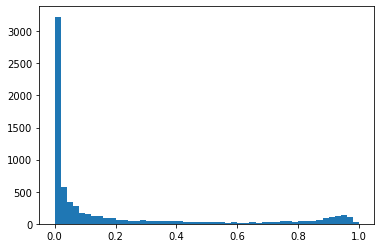

0.7781225756400311 0.4587211070230058
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5579
           1       0.81      0.74      0.78      1347

    accuracy                           0.92      6926
   macro avg       0.88      0.85      0.86      6926
weighted avg       0.92      0.92      0.92      6926

[[5351  228]
 [ 344 1003]]
0.7845303867403315


In [5]:
clf = grid_search.best_estimator_
clf

m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
clf.probability = True
CV_probs = cross_val_probs(clf, X1, y, gkf.split(X1,y,groups=groups))
import matplotlib.pyplot as plt
plt.hist(CV_probs,50)
plt.show()
# score, bias = Twobias_scorer_CV(CV_probs, y, True)
score, bias = f1Bias_scorer_CV(CV_probs, y, True)
predicted = np.asarray(CV_probs >= bias, dtype=np.int)
classified = range(n)
print(score,bias)

f = np.zeros((len(y),2))

data = pd.DataFrame()
print(metrics.classification_report(y, predicted))
print(metrics.confusion_matrix(y, predicted))

data['groups'] = groups
data['original'] = [[i] for i in y]
data['predicted'] = [[i] for i in predicted]
f_scores = []
data = data.groupby('groups').sum()
for i in range(data.shape[0]):
    f_scores.append(f1_score(data['original'][i],data['predicted'][i]))
print(np.median(f_scores))

In [6]:
print(X1.shape)
clf.fit(X1,y)
pickle.dump(clf,open('/home/jupyter/mullah/apply_cstress_to_rice/models/ecg_model.p','wb'))

(6926, 11)


In [ ]:
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
m = len(np.where(y==0)[0])
n = len(np.where(y>0)[0])
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from joblib import Parallel,delayed

delta = 0.1

paramGrid = {
             'pca__n_components':[4,5,6],
             'rf__kernel': ['rbf'],
             'rf__C': np.logspace(.1,4,3),
             'rf__gamma': [np.power(2,np.float(x)) for x in np.arange(-4, 0, .5)],
             'rf__class_weight': [{0: w, 1: 1 - w} for w in [.4,.3,.2]],
             'rf__probability':[True]
}

paramGrid = {
             'kernel': ['rbf'],
             'C': np.logspace(.1,4,3),
             'gamma': [np.power(2,np.float(x)) for x in np.arange(-4, 0, .5)],
             'class_weight': [{0: w, 1: 1 - w} for w in [.4,.3,.2]],
             'probability':[True]
}
# clf = Pipeline([('pca',PCA()),('rf', SVC())])
clf = SVC()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=list(gkf.split(X,y,groups=groups)),
                           scoring='f1_weighted',verbose=5)
grid_search.fit(X,y)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')
clf = grid_search.best_estimator_
y_pred = cross_val_predict(clf,X,y,cv=gkf.split(X,y,groups=groups))
print(confusion_matrix(y,y_pred),classification_report(y,y_pred))

In [ ]:
import pickle
print(clf)
clf.fit(X,y)
pickle.dump(clf,open('/home/jupyter/mullah/cc3/ecg_rip_model_feature_standardization_minnesota.p','wb'))

In [ ]:
from sklearn_porter import Porter
porter = Porter(clf, language='java')
output = porter.export(export_data=True)
# print(output)
text_file = open("SVM.java", "w")
text_file.write(output)
text_file.close()
print(clf.probA_,clf.probB_)